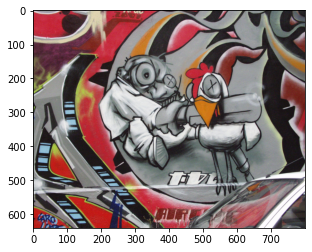

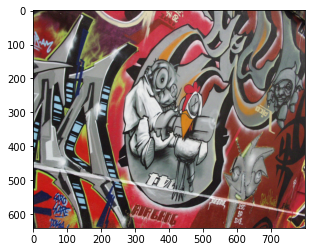

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pygcransac
from time import time

img1 = cv2.cvtColor(cv2.imread('img/grafA.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/grafB.png'), cv2.COLOR_BGR2RGB)
H_gt = np.linalg.inv(np.loadtxt('img/graf_model.txt'))
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [22]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.8
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

In [23]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, H, mask):
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [24]:
img1.shape

(640, 800, 3)

191.0 inliers found
0.0057942867279052734  sec cv2
323.0 inliers found
0.004698991775512695  sec gc-ransac


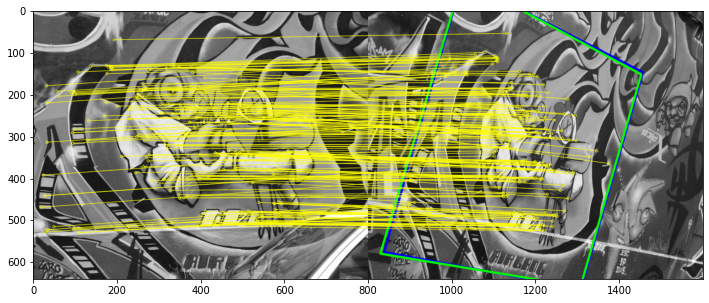

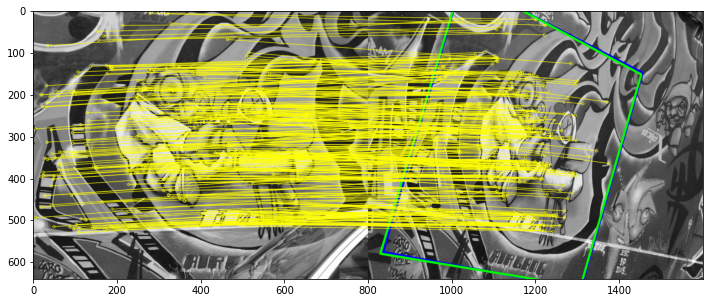

In [34]:
def get_probabilities(tentatives):
    probabilities = []
    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities

def verify_cv2(kps1, kps2, tentatives):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

def verify_pygcransac(kps1, kps2, tentatives, h1, w1, h2, w2, sampler_id):
    correspondences = np.float32([ (kps1[m.queryIdx].pt + kps2[m.trainIdx].pt) for m in tentatives ]).reshape(-1,4)
    inlier_probabilities = []

    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks.  
    if sampler_id == 3 or sampler_id == 4:
        inlier_probabilities = get_probabilities(tentatives)

    H, mask = pygcransac.findHomography(
        np.ascontiguousarray(correspondences), 
        h1, w1, h2, w2,
        use_sprt = False,
        spatial_coherence_weight = 0.1,
        neighborhood_size = 3,
        probabilities = inlier_probabilities,
        sampler = sampler_id,
        use_space_partitioning = True)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

t=time()
cv2_H, cv2_mask = verify_cv2(kps1,kps2,tentatives)
print (time()-t, ' sec cv2')
t=time()
mag_H, mag_mask = verify_pygcransac(kps1, kps2, tentatives, img1.shape[1], img1.shape[0],
                                img2.shape[1], img2.shape[0], 2)
print ((time()-t), ' sec gc-ransac')

draw_matches(kps1, kps2, tentatives, img1, img2, cv2_H, cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, mag_H, mag_mask)

#As you can see, magsac finds more inliers and more precise homography